In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy import stats
import os

import fortranformat as ff
import netCDF4

import operator
import functools
import netCDF4 as nc


#Tamu database for size parameter is neither linear nor exponential.For GRASP it is required for the size parameter to belognormally spaced. Hence we do the exponial fit of the data andlater extend the data to required range


0.16279100867003773 390.2269304989932 0.0295262467116117 11810.4990234375


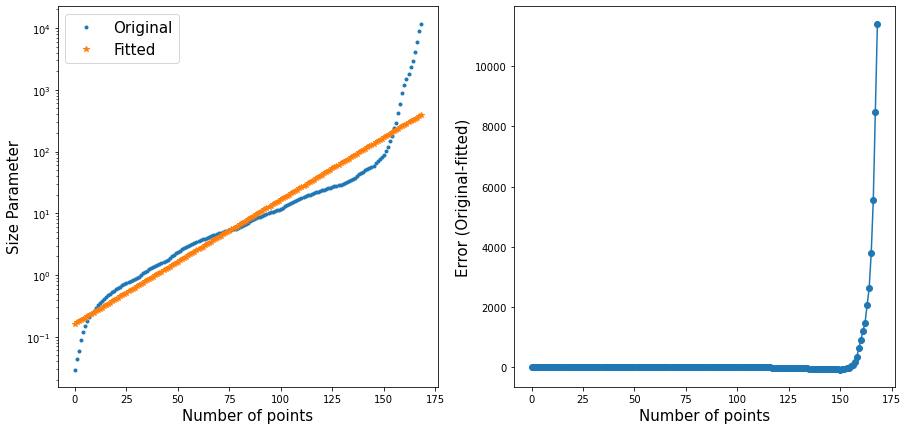

In [2]:
df= pd.read_csv("/home/gregmi/TAMU_project/DATABASE.csv")
fig, ax = plt.subplots(1,2, figsize=(15, 7))
ys = df['Size Parameter:']
xs = np.arange(0,169,1)[:len(ys) ]
ax[0].plot(xs, ys, '.', label='Original')

#Lognormal fitting of the original data
Pp = np.polyfit(xs, np.log(ys), 1)
fit = np.exp(Pp[1]) * np.exp(Pp[0] * xs)


#Plotting
ax[0].plot(xs, fit, '*', label = "Fitted")
ax[0].set_yscale('log')
ax[0].legend(fontsize=15)
ax[0].set_ylabel("Size Parameter", fontsize=15 )
ax[0].set_xlabel("Number of points",fontsize=15 )

diff = (ys-fit)

ax[1].plot(diff, marker ='o')
ax[1].set_ylabel("Error (Original-fitted)",fontsize=15 )
ax[1].set_xlabel("Number of points",fontsize=15 )

print(np.min(fit),np.max(fit), np.min(ys),np.max(ys) )

273
0.03872556175778054 11478.143008998231


Text(0.5, 1.0, 'Number of points: 273, Min:0.0387256 , Max:11478.143009 ')

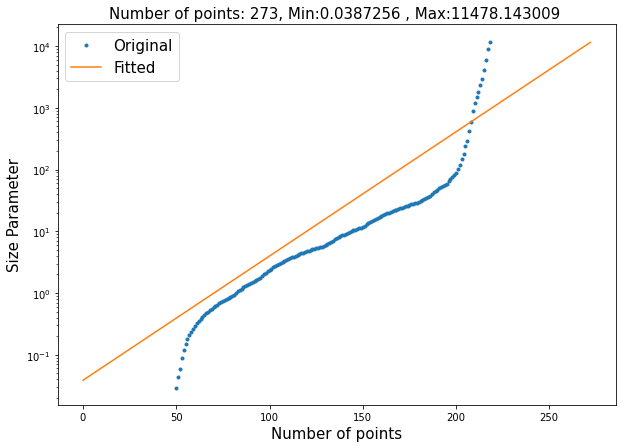

In [3]:
#Calculating the ratio of normal distribution 
for i in range(len(fit)-1):
    ratio = fit[i]/fit[i+1]
#     print(ratio)

#Adding more values in the fit to cover the both limits of the data
a = fit[0]
add_value=[]
for i in range(31):
    new = a *ratio
    add_value.append(new)
    a = new

b = fit[-1]
back_value=[]
for i in range(73):
    new = b /ratio
    back_value.append(new)
    b = new

data1 = np.concatenate((np.array(add_value[::-1]), np.array(fit)), axis=0)
data2 = np.concatenate((data1, np.array(back_value)), axis=0)


ys = df['Size Parameter:']
xs = np.arange(0,169,1)[:len(ys)]+50

fig =plt.figure(figsize=(10, 7))
plt.plot(xs, ys, '.', label='Original')
plt.plot(data2, label = "Fitted")
plt.yscale('log')
print(len(data2))
print(np.min(data2),np.max(data2)), np.min(df['Size Parameter:'])
plt.legend(fontsize=15)
plt.ylabel("Size Parameter",fontsize=15 )
plt.xlabel("Number of points",fontsize=15 )

plt.title(f"Number of points: {len(data2)}, Min:{round(np.min(data2),7)} , Max:{round(np.max(data2),7)} ",fontsize=15)

[1.3701     1.41343334 1.45676667 1.50010001 1.54343334 1.58676668
 1.63010001 1.67343335]


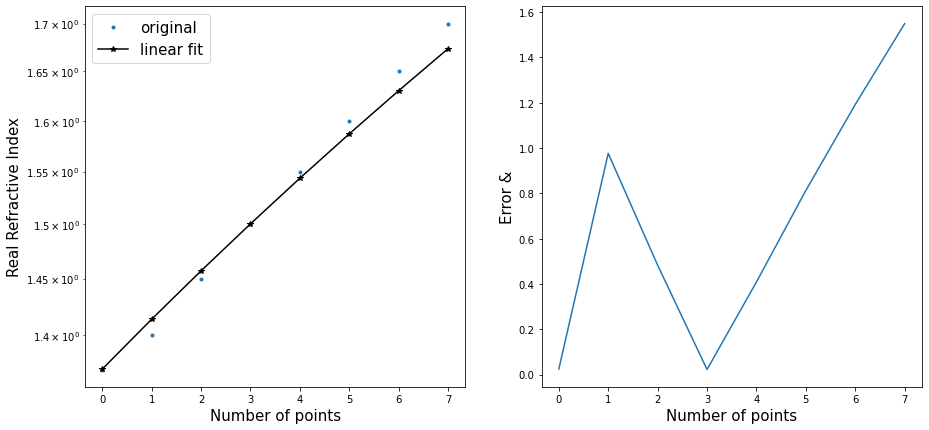

In [4]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ys = df['Real Refractive Index:'][:8]
xs=np.arange(0,len(ys),1)[:8]
ax[0].plot(xs, ys, '.', label='original')

ax[0].set_yscale('log')
ax[0].set_ylabel("Real Refractive Index",fontsize=15)
ax[0].set_xlabel("Number of points",fontsize=15)
#linear fit
linear = stats.linregress((xs,ys))
RI_fit = linear.intercept+0.012+(linear.slope-0.005)*xs  #values are adjusted 
ax[0].plot(xs,RI_fit, 'k',marker = "*", label='linear fit')

ax[0].set_yscale('log')
ax[0].legend(fontsize=15)
 

diff= abs(ys-RI_fit)
ax[1].plot(100*diff/ys)
ax[1].set_ylabel("Error &",fontsize=15)
ax[1].set_xlabel("Number of points",fontsize=15)
#fixing the bounds
RI= RI_fit
TAMU_min=1.3701
constant= TAMU_min - RI[0]
new_RI=RI+constant
print(new_RI)
ri=pd.DataFrame()
ri['RI']= new_RI

Text(0.5, 1.0, 'TAMUDUST2020 Database Imaginary Refractive Index')

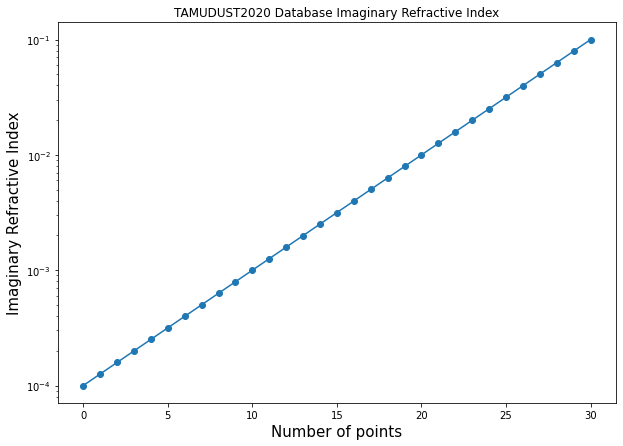

In [5]:
fig =plt.figure(figsize=(10, 7))
plt.plot(df['Imaginary Refractive Index:'],marker="o")
plt.yscale('log')
plt.ylabel("Imaginary Refractive Index",fontsize=15 )
plt.xlabel("Number of points",fontsize=15 )
plt.title("TAMUDUST2020 Database Imaginary Refractive Index")

In [6]:
wl=0.34 # in um
Diameter =(data2*wl)/(2*np.pi)    #from the definition of the size parameter in the TAMU DATA base which is 2*pi*D/wl
Radius =Diameter/2
len(Diameter)

#Diameter parameter file for TAMU

params_path = '/home/gregmi/TAMU_project/TAMUdust2020-v1.0/examples/params/TAMUdust2020_Size'
with open(params_path, "w") as file_object:
    for i in range(len(Diameter) ):
        file_object.write(f'{"{:.7e}".format(Diameter[i])}')

        file_object.write("\n")

#Wavelength parameter file for TAMU
Imag1 = df['Imaginary Refractive Index:'][:31].values

params_path_wl = "/home/gregmi/TAMU_project/TAMUdust2020-v1.0/examples/params/TAMUdust2020_Wavelength_exp1"
with open(params_path_wl, "w") as file_object:
    for i in range(len(Imag1)):

        file_object.write(f'{"{:.7e}".format(wl)}')
        file_object.write("\n")

In [7]:
#Storing the TAMU results for all the optical properites in the following lists #Scattering properties
Qext_max=[]
Qsca_max=[]
Area_max=[]
Volume_max=[]
Dimension_max=[]
SSA_max=[]

#Phase function
P11=[]
P12=[]
P22=[]
P33=[]
P43=[]
P44=[]

#We cannot change the TAMUdust angle range : (0,180,0.1). Extrating the values 
Angles =np.linspace(0,180,181)
Ang_format=[]
for i in range(181):
    Ang_format.append("{:.7E}".format(Angles[i]))
    
#Path to parameter files for refractive index
params_path="/home/gregmi/TAMU_project/TAMUdust2020-v1.0/examples/params/TAMUdust2020_RefractiveIndex_exp1"
output_path="/home/gregmi/TAMU_project/TAMUdust2020-v1.0/examples/output/TAMUdust2020create_exp1"


#TAMUdust2020create calculates optical properties at each wavelength.
#reapeating the values of wavelength and real refractive indices for different v
#updating the RI paramter files for each values of real imaginary refractive ind Imag1 - dfl'Imaginary Refractive Index:'][:31].values
for j in range (len(new_RI)):
        with open(params_path, "w") as file_object:
            for i in range(len(Imag1)):
                file_object.write("{:.5E}".format(new_RI[j])+' '+"\t"+"{: .5E}".format(Imag1[i]))
                file_object.write("\n")
#Running the TAMU2020 ( ../bin/tamudust2020create {NAMELIST})
        os.system('/home/gregmi/TAMU_project/TAMUdust2020-v1.0/bin/tamudust2020create /home/gregmi/TAMU_project/TAMUdust2020-v1.0/examples/TAMUdust2020create_exp1.nml')
    
        
        #Reading the output files
                                  
        fn_Scattering = output_path+'/isca.dat'
        df1 = pd.read_csv(fn_Scattering, delim_whitespace=True, usecols=[0, 1, 2, 3,4,5,6], names =["Wl","Dimension","Volume","Projected_area","Qe", "SSA","g"])
                                                                         
        Qext_max.append(df1["Qe"])
        Qsca_max.append(df1["Qe"]*df1["SSA"])#scattering efficiency
        Area_max.append(df1[ 'Projected_area'])
        Volume_max.append(df1['Volume'])
        Dimension_max.append(df1['Dimension'])
        SSA_max.append(df1["SSA"])
                                                                         
        fn_Scattering = output_path+'/P11.dat'
        df1 = pd.read_csv(fn_Scattering,delim_whitespace=True)
        P11.append(df1[Ang_format])
                                                                         
        fn_Scattering = output_path+'/P12.dat'
        dfl = pd.read_csv(fn_Scattering,delim_whitespace=True)
        P12.append(dfl[Ang_format])
                                                                         
        fn_Scattering = output_path+'/P22.dat'
        dfl = pd.read_csv(fn_Scattering, delim_whitespace=True)
        P22.append(dfl[Ang_format])
                                                                         
        fn_Scattering = output_path+'/P33.dat'
        dfl = pd.read_csv(fn_Scattering, delim_whitespace=True)
        P33.append(dfl[Ang_format])
                                                                         
        fn_Scattering = output_path+'/P44.dat'
        df1 = pd.read_csv(fn_Scattering, delim_whitespace=True) 
        P44.append(df1[Ang_format])
                                                                         
        fn_Scattering = output_path+'/P43.dat'
        df1 = pd.read_csv(fn_Scattering, delim_whitespace=True) 
        P43.append(df1[Ang_format])
        print("Done")

Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


Done


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


Done


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


Done


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


Done


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


Done


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


Done


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


Done


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


Done


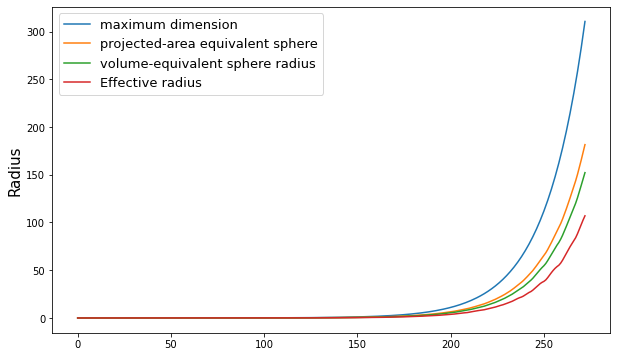

In [54]:
#reshaping all the TAMU output as (n_real_RI, n_imag_RI, n_size)

Dimension1 = np.array(Dimension_max).reshape(8,31,273)
Area1 =  np.array(Area_max).reshape(8,31,273)
Volume1 = np.array(Volume_max).reshape(8,31,273)
Qext1 = np.array(Qext_max).reshape(8,31,273)
Qsca1= np.array(Qsca_max).reshape(8,31,273)
Qabs1=Qext1-Qsca1
wl = "0.34000"

#UNcomment the folder name that you want to create

folder_name = "Ver_sph"  #Kernels with volume equivalent radius and using volume and area of the spheres
# calcuating radius from the volume
Radius_v = np.cbrt(3*Volume1[1,1,:]/(np.pi*4))
Radius = Radius_v
#The GARSP Kernels inputs bext *lnr
dlnr = np.log(Radius_v[1]/Radius_v[0])
#Uncomment this if you want to use the volume and area of sphere
b_ext = Qext1*3*dlnr/(4*Radius_v)
b_abs = Qabs1*3*dlnr/(4*Radius_v)





# folder_name = "Ver_TAMU" #kernels with volume equivalent radius and using volume and area definition of TAMU
# Radius_v = np.cbrt(3*Volume1[1,1,:]/(np.pi*4))
# dlnr = np.log(Radius_v[1]/Radius_v[0])
# b_ext = (Qext1 *Area1 *dlnr)/Volume1
# b_abs = (Qabs1 *Area1 *dlnr)/Volume1


# folder_name = "Eff_sph"  #Kernels with effiective radius and using volume and area of the spheres
# Radius_v =3*Volume1[1,1,:]/(4*Area1[1,1,:])
# Radius = Radius_v
# dlnr = np.log(Radius_v[1]/Radius_v[0])
# b_ext = Qext1*3*dlnr/(4*Radius_v)
# b_abs = Qabs1*3*dlnr/(4*Radius_v)



# folder_name = "Eff_TAMU" #kernels with effective radius and using volume and area definition of TAMU
# Radius_v =3*Volume1[1,1,:]/(4*Area1[1,1,:])
# Radius = Radius_v
# dlnr = np.log(Radius_v[1]/Radius_v[0])
# b_ext = (Qext1 *Area1 *dlnr)/(4*Volume1)
# b_abs = (Qabs1 *Area1 *dlnr)/(4*Volume1)


#Calculating the b_scattering
b_sca = b_ext - b_abs


#Calculation of radius
plt.figure(figsize =(10,6))
plt.plot(Dimension1[0,24,:]/2, label ="maximum dimension")
plt.plot(np.sqrt(Area1[0,24,:]/np.pi),label ="projected-area equivalent sphere")
plt.plot(np.cbrt(3*Volume1[0,24,:]/(np.pi*4)),label ="volume-equivalent sphere radius")
plt.plot(3*Volume1[0,24,:]/(4*Area1[0,24,:]), label= "Effective radius")
plt.ylabel("Radius", fontsize=15)
plt.legend( fontsize =13)






In [56]:
np.save('Radius_vol.npy', Radius_v)
# np.save("Real_RI.npy", new_RI)
# np.save("Imag_RI.npy", df['Imaginary Refractive Index:'][:31].values )
# np.save('Area1.npy', Area1)
# np.save("P11_TAMU.npy", P11)
# np.save("P12_TAMU.npy", P12)
# np.save("Imag_RI.npy", df['Imaginary Refractive Index:'][:31].values )

In [41]:
from scipy import interpolate
from scipy.interpolate import CubicSpline

In [57]:
T_real= np.load("Real_RI.npy")
T_imag =np.load("Imag_RI.npy")
T_radius = np.load("Radius_vol.npy")
ang = np.arange(0,181,1)

In [58]:
fn = f'/home/gregmi/GRASP_scripts/GRASP_TAMU/100_00.nc4'
ds1 = nc.Dataset(fn, 'r')
GRASP_r = np.array(ds1.variables["r"][:])
real_ri = np.array(ds1.variables["n"][:])
imag_ri = np.array(ds1.variables["k"][::-1])

Radius_v = T_radius
dlnr = np.log(Radius_v[1]/Radius_v[0])
dlnr_grasp = np.log(GRASP_r[1]/GRASP_r[0])


val =np.zeros((8,31,41))

z1 = np.array(ds1.variables["b_ext"][:,:,:])

for i in range(41):
    z = z1[:,:,i]
    f = interpolate.interp2d( imag_ri, real_ri , z, kind='cubic',fill_value="extrapolate")
    cubic_r = f(T_imag,T_real)
    val[:,:,i] = cubic_r

print(np.array(val).shape)
b_ext =np.zeros((8,31,273))

for i in range(8):
    for j in range(31):
        z = np.array(val)[i,j,:]
        f = interpolate.Akima1DInterpolator( GRASP_r, z) 
        b_ext[i,j,:] = f.__call__(T_radius)





(8, 31, 41)


In [59]:

Dimension1 = np.array(Dimension_max).reshape(8,31,273)
Area1 =  np.array(Area_max).reshape(8,31,273)
Volume1 = np.array(Volume_max).reshape(8,31,273)
Qext1 = np.array(Qext_max).reshape(8,31,273)
Qsca1= np.array(Qsca_max).reshape(8,31,273)
Qabs1=Qext1-Qsca1
wl = "0.34000"

In [60]:
fn = f'/home/gregmi/GRASP_scripts/GRASP_TAMU/100_00.nc4'
ds1 = nc.Dataset(fn, 'r')
GRASP_r = np.array(ds1.variables["r"][:])
real_ri = np.array(ds1.variables["n"][:])
imag_ri = np.array(ds1.variables["k"][::-1])

Radius_v = T_radius
dlnr = np.log(Radius_v[1]/Radius_v[0])
dlnr_grasp = np.log(GRASP_r[1]/GRASP_r[0])


val =np.zeros((8,31,41))

z1 = np.array(ds1.variables["b_abs"][:,:,:])

for i in range(41):
    z = z1[:,:,i]
    f = interpolate.interp2d( imag_ri, real_ri , z, kind='cubic')
    cubic_r = f(T_imag,T_real)
    val[:,:,i] = cubic_r

print(np.array(val).shape)
b_abs =np.zeros((8,31,273))
for i in range(8):
    for j in range(31):
        z = np.array(val)[i,j,:]
        f = interpolate.Akima1DInterpolator( GRASP_r, z) 
        b_abs[i,j,:] = f(T_radius)





(8, 31, 41)


## Instad of extrapolation substituting the values from TAMU for the radius greater than Grasp_radius max or > 33 

In [61]:
b_ext[:,:,239:] = Qext1[:,:,239:]
b_abs[:,:,239:] = Qabs1[:,:,239:]

In [62]:
def Sph_akima(Phase_read):
#reading the phase function files
    fn = f'/home/gregmi/GRASP_scripts/GRASP_TAMU/{Phase_read}.nc4'
    ds1 = nc.Dataset(fn, 'r')
    #Reading the extinction files
    fn_q = f'/home/gregmi/GRASP_scripts/GRASP_TAMU/100_00.nc4'
    ds_q = nc.Dataset(fn_q, 'r')
    b_ext_g = np.array(ds_q.variables["b_ext"][:])
    b_abs_g = np.array(ds_q.variables["b_abs"][:])
    b_sca_g = b_ext_g-b_abs_g

    P11_sca = ds1.variables["P11"]
    GRASP_r = np.array(ds1.variables["r"][:])
    real_ri = np.array(ds1.variables["n"][:])
    imag_ri = np.array(ds1.variables["k"][::-1])
    ang = np.arange(0,181,1)

    sph = np.zeros((22,16,273,181))
    #Interpolating between the size parameters and angle
    for i in range (22):
        for j in range(16):
            for k in range(181):
            
                z = P11_sca[i,j,:,k]
                f = interpolate.Akima1DInterpolator(GRASP_r, z)
                cubic_r = f.__call__(T_radius,0,extrapolate="None")
                sph[i,j,:,k] = cubic_r
    
    print(np.array(sph).shape)
    
   
    val1= np.zeros((8,31,273,181))
    for i in range(181):
        for j in range(273):
            z = sph[:,:,j,i]
            f = interpolate.interp2d( imag_ri,real_ri, z, kind='cubic')
            cubic_r = f(T_imag,T_real)
            val1[:,:,j,i] = cubic_r
            

    val1.shape
    print("DONE")
    return val1, sph


In [63]:
P11_sph = Sph_akima('11')
P12_sph = Sph_akima('12')
P22_sph = Sph_akima('22')
P33_sph = Sph_akima('33')
P34_sph = Sph_akima('34')
P44_sph = Sph_akima('44')

(22, 16, 273, 181)
DONE
(22, 16, 273, 181)
DONE
(22, 16, 273, 181)
DONE
(22, 16, 273, 181)
DONE
(22, 16, 273, 181)
DONE
(22, 16, 273, 181)
DONE


In [64]:
P11_sph[0][:,:,239:,:] = np.array(P11).reshape(8,31,273,181)[:,:,239:,:]
P12_sph[0][:,:,239:,:] = np.array(P12).reshape(8,31,273,181)[:,:,239:,:]
P22_sph[0][:,:,239:,:] = np.array(P22).reshape(8,31,273,181)[:,:,239:,:]
P33_sph[0][:,:,239:,:] = np.array(P33).reshape(8,31,273,181)[:,:,239:,:]
P34_sph[0][:,:,239:,:] = -np.array(P43).reshape(8,31,273,181)[:,:,239:,:]
P44_sph[0][:,:,239:,:] =  np.array(P44).reshape(8,31,273,181)[:,:,239:,:]


In [66]:


wl='0.34000'#used wavelength

new_RI =T_real
Radius_v = T_radius
Imag1 = T_imag #Read imaginary refrac 
Radius_v = T_radius
dlnr = np.log(Radius_v[1]/Radius_v[0])
dlnr_grasp = np.log(GRASP_r[1]/GRASP_r[0])
    

with open(f'/home/shared/GRASP_GSFC/src/retrieval/internal_files/{folder_name}/kernels_100_00.txt','w')as f:
    
    f.write(f'{ "%s %s"%("{:.6E}".format(min(Radius_v)),"{:.6E}".format(max(Radius_v)))}  1.00000\n') 
    f.write(f'{-len(Radius_v)}   number of grid radii\n') 
    f.write(f'{"%s %s"%("{:.8}".format(min(new_RI)),"{:.8}".format(max(new_RI)))}  range of real refr. index\n')
    f.write(f'{"%s %s"%("{:.7E}".format(-min(Imag1)), "{:.7E}".format(-max(Imag1)))}  range of imag refr. index\n') #range of imaginary refractive index
    f.write(f'{"%s %s"%(len(new_RI),-len(Imag1))}   number of nodes for real and imag parts of refr. index')


    for i in range (len(new_RI)):           #loop over real RI
        for j in range(len(Imag1)):          #loop over imag RI
            f.write("\n")
            f.write(f' 0 1.00000 element, ratio \n')
            f.write(f'{"%s %s %s" %(wl,"{:.7}".format(new_RI[i]),"{:.7E}".format(-Imag1[j]))}   wavel, rreal, rimag\n')

            f.write("EXTINCTION (1/um):\n")
            for k in range (len(b_ext[0][0])): #loop over size parameters or dia 
                f.write("{:.7E}".format(float(b_ext[i][j][k])*dlnr/dlnr_grasp)+'\t') 
            f.write("\n")

            f.write("ABSORPTION (1/um):\n")
            for k in range (len(b_abs[0][0])): #loop over size parameters or di
                f.write("{:.7E}".format(float(b_abs[i][j][k])*dlnr/dlnr_grasp)+'\t')
        print(f"Done{i}")
    f.write('\n') 
    f.write('Shape distribution:\n')

    f.write("1 nr \n")
    f.write("#       r    rd \n")
    f.write("1      1.00000      0.100000E+01")

Done0
Done1
Done2
Done3
Done4
Done5
Done6
Done7


In [67]:
def Phase_Function_11(P11,a):

    #These files stores the output form TAMU simualtion for radius, real and imagianry RI
    fn = f'/home/gregmi/GRASP_scripts/GRASP_TAMU/{a}.nc4'
    ds1 = nc.Dataset(fn, 'r')

    wl='0.34000'#used wavelength
    Angles =np.linspace(0,180,181)
    new_RI =T_real       #real refractive index
    Radius_v = T_radius  #Radius

    dlnr = np.log(T_radius[1]/T_radius[0])
    dlnr_grasp = np.log(GRASP_r[1]/GRASP_r[0]) #this factor is important for the interpolation kernel. 
    print(dlnr, dlnr_grasp) 

            
    df= pd.read_csv("/home/gregmi/TAMU_project/DATABASE.csv")
    Imag1 = T_imag #Read imaginary refrac 
#.............................................................................................

    
    #Location where kernels files should be created
    with open(f'/home/shared/GRASP_GSFC/src/retrieval/internal_files/{folder_name}/kernels_100_{a}.txt', 'w') as f:
        print(f'kernels_100_{a}.txt')
        f.write(f'{"%s %s"%("{:.6}".format(min(Radius_v)),"{:.6}".format(max(Radius_v)))} \t 1.00000\n') 
        f.write(f'{-len(Radius_v)}   number of grid radii\n') 
        f.write(f'\t 181   number of scattering angles\n')
                    
        for ang in range(181):
            f.write(f'{("{:.3f}".format(Angles[ang]))}\t')
            if (ang%10==9):
                f.write(f'\n')
        f.write(f'\n')
        f.write(f'{"%s %s"%("{:.8}".format(min(new_RI)),"{:.8}".format(max(new_RI)))}  range of real refr. index\n')
        f.write(f'{"%s %s"%("{:.7E}".format(-min(Imag1)), "{:.7E}".format(-max(Imag1)))}  range of imag refr. index\n') #range of imaginary refractive index
        f.write(f'{"%s %s"%(len(new_RI),-len(Imag1))}   number of nodes for real and imag parts of refr. index \n')


        for i in range (len(new_RI)):
            for j in range(len(Imag1)):

                #1o0p over real RI
                #loop over imag RI

                f.write(f' {a}    1.00000 element, ratio \n')
                f.write(f'{"%s %s %s" %(wl,"{:.7}".format(new_RI[i]),"{:.7E}".format(-Imag1[j]))}   wavel, rreal, rimag\n')

                for k in range (273): #loop over size parameters or diameters
                    for ang in range(181):
                        # P11_sca = P11[i][j][k][ang]*(dlnr/dlnr_grasp)
                        P11_sca = P11[i][j][k][ang]*(dlnr/dlnr_grasp)
                        # f.write(Dec_7(P11_sca)+'\t')
                        f.write(f'{"%s"%("{:.7E}".format(P11_sca))}\t')
                    f.write("\n")
            # print(f"Done{i}")
        f.write('\n') 
        f.write('Shape distribution:\n')

        f.write("1 nr \n")
        f.write("#       r    rd \n")
        f.write("1     1.00000      0.100000E+01")

In [68]:
Phase_Function_11(P11_sph[0],11)
Phase_Function_11(P12_sph[0],12)
Phase_Function_11(P22_sph[0],22)
Phase_Function_11(P33_sph[0],33)
Phase_Function_11(P34_sph[0],34)
Phase_Function_11(P44_sph[0],44)

0.05326875764664636 0.2716087
kernels_100_11.txt
0.05326875764664636 0.2716087
kernels_100_12.txt
0.05326875764664636 0.2716087
kernels_100_22.txt
0.05326875764664636 0.2716087
kernels_100_33.txt
0.05326875764664636 0.2716087
kernels_100_34.txt
0.05326875764664636 0.2716087
kernels_100_44.txt
